In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --no-index scikit-learn
!pip install --no-index seaborn

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic


In [3]:
import numpy as np
from scipy import stats
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from decode_utils import decode, get_percent_correct_from_proba, get_fa, get_dprime, get_train_test_indices
from tqdm import tqdm
from scipy.stats import zscore, norm
#import h5py
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from scipy.stats import zscore, norm
from sklearn import preprocessing
import os
from datetime import datetime
import json

In [6]:
import numpy as np
import logging
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import torch
import matplotlib.pyplot as plt

class DecayAnalyzer:
    def __init__(self, decay=10):
        self.decay = decay
        self.logger = self._setup_logger()
        self.lb = ['bear', 'elephant', 'person', 'car', 'dog', 'apple', 'chair', 'plane', 'bird', 'zebra']
    
    def _setup_logger(self):
        """Set up a logger for debugging."""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            filename='ml_debug.log'
        )
        return logging.getLogger('MLDebug')
    
    def analyze_all_delays(self, delays):
        """Analyze multiple delays and return results."""
        results = {}
        accuracies = []
        
        for delay in delays:
            print(f"\nAnalyzing delay {delay}ms...")
            i1, acc = self.analyze_single_delay(delay)
            results[delay] = i1
            accuracies.append(acc)
            print(f"Accuracy: {acc:.3f}")
        
        print("\nOverall Behavioral Accuracies:")
        for delay, acc in zip(delays, accuracies):
            print(f"Delay {delay}ms: {acc:.3f}")
            
        return results, accuracies
    
    def analyze_single_delay(self, delay_ms):
        """Analyze a single delay condition."""
        # Load and prepare features
        features, labels = self._load_features(delay_ms)
        nrImages = features.shape[0]
        features = features.reshape(nrImages, -1)
        
        # Initialize result array
        i_1 = np.zeros((nrImages, 20), dtype=float)
        i_1[:] = np.NAN
        
        # Perform decoding iterations
        for j in tqdm(range(20), desc=f"{delay_ms = }"):
            p = self._decode(features, labels, seed=j, nrfolds=3)
            pc = self._get_percent_correct(p, labels)
            i_1[:,j] = np.nanmean(pc, axis=1)
        
        overall_accuracy = np.nanmean(i_1)
        return i_1, overall_accuracy
    
    def _load_features(self, delay_ms):
        """Load features from file."""
        features_path = f"extracted_features_fc_layer/{self.decay}decay/features_delay{delay_ms}ms.pt"
        features_dict = torch.load(features_path, map_location="cpu")
        features = features_dict["post_decay"].detach().cpu().numpy()
        labels = features_dict["labels"].detach().cpu().numpy()
        return features, labels
    
    def _decode(self, features, labels, nrfolds=3, seed=0):
        """Perform decoding while preserving relative scales."""
        classes = np.unique(labels)
        nrImages = features.shape[0]
        
        # Center features but preserve scale
        features = features - np.mean(features, axis=0, keepdims=True)
        
        # Initialize probability array
        prob = np.zeros((nrImages, len(classes)))
        prob[:] = np.NAN
        
        # Perform cross-validation
        for i in range(nrfolds):
            train, test = get_train_test_indices(nrImages, nrfolds=nrfolds, foldnumber=i, seed=seed)
            
            # Train classifier
            clf = LogisticRegression(
                penalty='l2',
                C=1.0,
                max_iter=1000,
                class_weight='balanced'
            ).fit(features[train], labels[train])
            
            # Predict probabilities
            prob[test] = clf.predict_proba(features[test])
        
        return prob
    
    def _get_percent_correct(self, prob, labels):
        """Calculate percent correct from probabilities."""
        return get_percent_correct_from_proba(prob, labels, np.array(self.lb))


def load_reliability_data(delay: int, base_dir: str = "behavioral_metrics_results") -> np.ndarray:
    """Load reliability data for a specific delay"""
    reliability_path = os.path.join(base_dir, f'delay_{delay}ms/bi1/reliabilities.npy')
    return np.load(reliability_path)

def load_model_data(delay: int, decay:float):
    analyzer = DecayAnalyzer(decay=decay)
    results, accuracies = analyzer.analyze_all_delays([delay])
    return np.nanmean(results[delay], axis=1)

def load_monkey_data(delay: int, base_dir: str):
    monkey_template = "b_i1_delay_{}.npy"
    monkey_template = monkey_template.format(delay)
    monkey_file = os.path.join(base_dir, monkey_template)
    monkey_data = np.load(monkey_file)
    return monkey_data.ravel()

def calculate_corrected_correlation(
    model_data: np.ndarray,
    monkey_data: np.ndarray,
    monkey_reliability: np.ndarray
):
    """
    Calculate noise-ceiling corrected correlation and its standard deviation
    """
    # Calculate raw correlation
    raw_corr, p_val = stats.pearsonr(model_data, monkey_data)
    
    # Calculate corrected correlations for each reliability value
    corrected_corrs = []
    for rel in monkey_reliability:
        # Correct correlation by dividing by sqrt(reliability)
        corrected_corr = raw_corr / np.sqrt(rel)
        # Ensure correlation doesn't exceed 1
        corrected_corr = min(corrected_corr, 1.0)
        corrected_corrs.append(corrected_corr)
    
    # Calculate mean and std of corrected correlations
    mean_corrected = np.mean(corrected_corrs)
    std_corrected = np.std(corrected_corrs)
    
    return raw_corr, mean_corrected, std_corrected, p_val

def create_results_directory(decay: float):
    """
    Create a directory for storing correlation results.
    Returns the path to the created directory.
    """
    base_dir = "fc_layer/correlation_monkey_and_model_noise_ceiling"
    # Add timestamp to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # results_dir = f"{base_dir}_{timestamp}"
    results_dir = f"{base_dir}_{decay}"
    
    
    # Create directory if it doesn't exist
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        print(f"Created results directory: {results_dir}")
    
    return results_dir

def plot_correlation_summary_with_error(
    results,
    results_dir: str,
    filename: str = 'correlation_summary_simple.png'
):
    """
    Create a simple bar plot with error bars from correlation results
    """
    plt.figure(figsize=(10, 6))
    
    # Extract data
    delays = [int(delay) for delay in results.keys()]
    correlations = [result['corrected_correlation'] for result in results.values()]
    errors = [result['correlation_std'] for result in results.values()]
    
    # Create bar plot with error bars
    plt.bar(delays, correlations,
            width=200,
            edgecolor='black',
            linewidth=1.5,
            yerr=errors,
            capsize=0,
            error_kw={'linewidth': 1.5})
    
    # Save plot
    save_path = os.path.join(results_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Saved simple correlation plot: {save_path}")


def plot_correlation(model_data, monkey_data, delay, r, p):
    """
    Create a scatter plot of model vs monkey behavioral data.
    
    Parameters:
    -----------
    model_data : array-like
        Model behavioral data
    monkey_data : array-like
        Monkey behavioral data
    delay : int
        Delay time in milliseconds
    r : float
        Correlation coefficient
    p : float
        P-value of correlation
    """
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot
    sns.scatterplot(x=monkey_data, y=model_data, alpha=0.5)
    
    # Add correlation line
    z = np.polyfit(monkey_data, model_data, 1)
    p_fit = np.poly1d(z)
    plt.plot(monkey_data, p_fit(monkey_data), "r--", alpha=0.8, label='Correlation Line')
    
    # Add labels and title
    plt.xlabel('Monkey Behavior')
    plt.ylabel('Model Behavior')
    plt.title(f'Model vs Monkey Behavior Correlation\nDelay: {delay}ms, r={r:.3f}, p={p:.3e}')
    
    # Add unity line
    min_val = min(plt.xlim()[0], plt.ylim()[0])
    max_val = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Unity Line')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    return plt.gcf()

def process_all_delays_with_reliability(
    delays,
    monkey_path: str,
    decay: float = 1.5,
    reliability_base_dir: str = "behavioral_metrics_results"
):
    """
    Process and save results for all delays with reliability correction
    """
    # Create results directory
    results_dir = create_results_directory(decay=decay)
    
    # Dictionary to store all results
    all_results = {}
    
    # Process each delay
    for delay in delays:
        print(f"\nProcessing delay: {delay}ms")
        
        # Load behavior data
        monkey_data = load_monkey_data(delay=delay, base_dir=monkey_path)
        model_data = load_model_data(delay=delay, decay=decay)
        
        # Load reliability data
        reliability_data = load_reliability_data(delay=delay, base_dir=reliability_base_dir)

        
        # Calculate corrected correlation
        raw_r, corrected_r, r_std, p_value = calculate_corrected_correlation(
            model_data, monkey_data, reliability_data
        )
        
        # Store results
        all_results[str(delay)] = {
            'raw_correlation': float(raw_r),
            'corrected_correlation': float(corrected_r),
            'correlation_std': float(r_std),
            'p_value': float(p_value)
        }
        
        # Create and save individual correlation plots
        fig = plot_correlation(model_data, monkey_data, delay, corrected_r, p_value)
        plot_filename = os.path.join(results_dir, f'correlation_plot_{delay}ms.png')
        fig.savefig(plot_filename)
        plt.close(fig)
        
        # Save raw data
        data_filename = os.path.join(results_dir, f'correlation_data_{delay}ms.npz')
        np.savez(data_filename,
                 model_data=model_data,
                 monkey_data=monkey_data,
                 reliability_data=reliability_data)
    
    # Create and save summary plot with error bars
    plot_correlation_summary_with_error(all_results, results_dir)
    
    # Save summary results
    results_filename = os.path.join(results_dir, 'correlation_results.json')
    with open(results_filename, 'w') as f:
        json.dump(all_results, f, indent=4)
    
    return results_dir, all_results

def plot_multiple_behavioral_accuracies(all_accuracies, delays, decay_rates, save_path=None):
    """
    Plot multiple behavioral accuracies on the same plot with different colors.
    
    Args:
        all_accuracies (list): List of lists containing accuracy values for each decay rate
        delays (array-like): List of delay values in milliseconds
        decay_rates (list): List of decay rates used
        save_path (str or Path, optional): Path to save the plot image
    """
    # Define same color palette as decay curves
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    # Create figure
    plt.figure(figsize=(8, 8))
    
    # Plot each accuracy curve with a different color
    for i, (accuracies, decay_rate) in enumerate(zip(all_accuracies, decay_rates)):
        color = colors[i % len(colors)]  # Use same color cycling as decay plot
        plt.plot(delays, accuracies, 'o-', 
                color=color,
                linewidth=2, 
                markersize=8,
                label=f'Decay rate = {decay_rate:.1f}')
    
    # Customize plot
    plt.title('Behavioral Accuracy vs Delay for Different Decay Rates', fontsize=14)
    plt.xlabel('Delay (ms)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.grid(False)
    
    # Set x-axis ticks to match delays
    plt.xticks(delays, fontsize=10)
    
    # Set y-axis limits
    plt.ylim(0.5, 1.0)
    
    # Add legend
    plt.legend(fontsize=10)
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save the plot if a path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()


def convert_to_number(rate_str):
    """
    Convert string to either int or float based on decimal point presence
    """
    return float(rate_str) if '.' in rate_str else int(rate_str)


def plot_multiple_correlation_summaries(all_decay_results, save_path=None):
    """
    Create a combined bar plot showing correlations for all decay rates with better spacing.
    
    Args:
        all_decay_results (dict): Dictionary with decay rates as keys and correlation results as values
        save_path (str, optional): Path to save the combined plot
    """
    # Define color palette in specific order
    colors = ['b', 'g', 'r', 'c', 'm']
    
    plt.figure(figsize=(8, 8))
    
    # Calculate bar positions
    delays = [int(delay) for delay in list(all_decay_results.values())[0].keys()]
    n_decays = len(all_decay_results)
    bar_width = 100  # Width of each bar
    group_spacing = 600  # Space between delay groups
    
    # Sort decay rates to ensure consistent order
    decay_rates = sorted([convert_to_number(rate) for rate in all_decay_results.keys()])
    
    # Plot bars for each delay group
    for i, delay in enumerate(delays):
        for j, decay_rate in enumerate(decay_rates):
            # Extract data
            results = all_decay_results[str(decay_rate)]
            correlation = results[str(delay)]['corrected_correlation']
            error = results[str(delay)]['correlation_std']
            
            # Calculate bar position
            bar_position = i * group_spacing + (j - n_decays/2 + 0.5) * bar_width
            
            # Create bar plot with error bars
            plt.bar(bar_position, 
                   correlation,
                   width=bar_width,
                   color=colors[j],
                   edgecolor='black',
                   linewidth=1.5,
                   label=f'Decay rate = {decay_rate:.1f}' if i == 0 else "")
            
            # Add error bars
            plt.errorbar(bar_position, 
                        correlation, 
                        yerr=error,
                        fmt='none',
                        color='black',
                        capsize=0,
                        linewidth=1.5)
    
    # Customize plot
    plt.xlabel('Delay (ms)', fontsize=12)
    plt.ylabel('Corrected Correlation', fontsize=12)
    plt.title('Model-Monkey Correlation vs Delay\nfor Different Decay Rates', fontsize=14)
    
    # Set x-axis ticks to center of each group
    tick_positions = [i * group_spacing for i in range(len(delays))]
    plt.xticks(tick_positions, delays, fontsize=10)
    
    # Set y-axis limits
    plt.ylim(0, 0.35)
    
    # Add legend
    plt.legend(fontsize=10, loc='upper right')
    
    # Remove top and right spines
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(False)
    
    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nSaved combined correlation plot: {save_path}")
    
    plt.show()

def process_all_decays_and_delays(
    decay_rates,
    delays,
    monkey_path: str,
    reliability_base_dir: str = "behavioral_metrics_results"
):
    """
    Process and plot results for all decay rates and delays
    """
    all_decay_results = {}
    
    # Process each decay rate
    for decay_rate in decay_rates:
        print(f"\nProcessing decay rate: {decay_rate}")
        results_dir, results = process_all_delays_with_reliability(
            delays=delays,
            monkey_path=monkey_path,
            decay=decay_rate,
            reliability_base_dir=reliability_base_dir
        )
        all_decay_results[str(decay_rate)] = results
    
    # Create combined plot
    plot_multiple_correlation_summaries(
        all_decay_results,
        save_path=os.path.join(os.path.dirname(results_dir), 'combined_correlation_summary.png')
    )
    
    return all_decay_results


Analyzing delay 0ms...


delay_ms = 0: 100%|██████████| 20/20 [00:00<00:00, 53.02it/s]


Accuracy: 0.869

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 53.75it/s]


Accuracy: 0.869

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 53.43it/s]


Accuracy: 0.869

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 56.88it/s]


Accuracy: 0.868

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 58.73it/s]


Accuracy: 0.867

Overall Behavioral Accuracies:
Delay 0ms: 0.869
Delay 100ms: 0.869
Delay 400ms: 0.869
Delay 800ms: 0.868
Delay 1200ms: 0.867

Analyzing delay 0ms...


delay_ms = 0: 100%|██████████| 20/20 [00:00<00:00, 53.69it/s]


Accuracy: 0.869

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 57.78it/s]


Accuracy: 0.868

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 72.48it/s]


Accuracy: 0.861

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 88.63it/s]


Accuracy: 0.845

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 98.38it/s]


Accuracy: 0.821

Overall Behavioral Accuracies:
Delay 0ms: 0.869
Delay 100ms: 0.868
Delay 400ms: 0.861
Delay 800ms: 0.845
Delay 1200ms: 0.821

Analyzing delay 0ms...


delay_ms = 0: 100%|██████████| 20/20 [00:00<00:00, 53.59it/s]


Accuracy: 0.869

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 60.88it/s]


Accuracy: 0.867

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 81.90it/s]


Accuracy: 0.854

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 98.65it/s]


Accuracy: 0.821

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 100.92it/s]


Accuracy: 0.760

Overall Behavioral Accuracies:
Delay 0ms: 0.869
Delay 100ms: 0.867
Delay 400ms: 0.854
Delay 800ms: 0.821
Delay 1200ms: 0.760

Analyzing delay 0ms...


delay_ms = 0: 100%|██████████| 20/20 [00:00<00:00, 53.98it/s]


Accuracy: 0.869

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 65.15it/s]


Accuracy: 0.865

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 94.59it/s]


Accuracy: 0.834

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 100.83it/s]


Accuracy: 0.733

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 123.14it/s]


Accuracy: 0.585

Overall Behavioral Accuracies:
Delay 0ms: 0.869
Delay 100ms: 0.865
Delay 400ms: 0.834
Delay 800ms: 0.733
Delay 1200ms: 0.585

Analyzing delay 0ms...


delay_ms = 0: 100%|██████████| 20/20 [00:00<00:00, 53.63it/s]


Accuracy: 0.869

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 94.02it/s]


Accuracy: 0.834

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 143.55it/s]


Accuracy: 0.515

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 164.05it/s]


Accuracy: 0.500

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 185.07it/s]


Accuracy: 0.500

Overall Behavioral Accuracies:
Delay 0ms: 0.869
Delay 100ms: 0.834
Delay 400ms: 0.515
Delay 800ms: 0.500
Delay 1200ms: 0.500
Plot saved to: fc_layer_combined_behavioral_accuracies.png


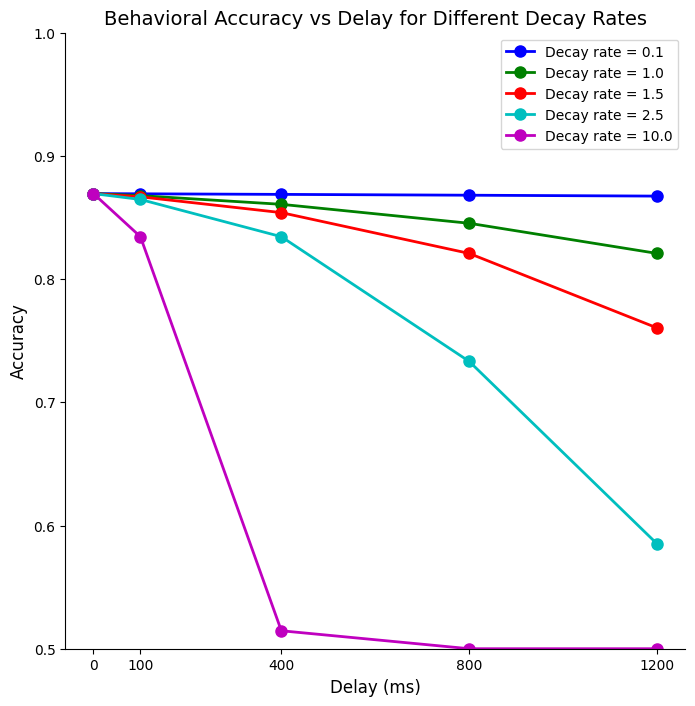

In [11]:
decay_rates = [0.1, 1, 1.5, 2.5, 10]
delays = [0, 100, 400, 800, 1200]
all_accuracies = []

# Collect all accuracies
for decay_rate in decay_rates:
    analyzer = DecayAnalyzer(decay=decay_rate)
    results, accuracies = analyzer.analyze_all_delays(delays)
    all_accuracies.append(accuracies)

# Create single plot with all accuracy curves
plot_multiple_behavioral_accuracies(all_accuracies, delays, decay_rates, save_path='fc_layer_combined_behavioral_accuracies.png')


Processing decay rate: 0.1

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 53.93it/s]


Accuracy: 0.869

Overall Behavioral Accuracies:
Delay 100ms: 0.869

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 55.85it/s]


Accuracy: 0.869

Overall Behavioral Accuracies:
Delay 400ms: 0.869

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 56.97it/s]


Accuracy: 0.868

Overall Behavioral Accuracies:
Delay 800ms: 0.868

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 59.19it/s]


Accuracy: 0.867

Overall Behavioral Accuracies:
Delay 1200ms: 0.867
Saved simple correlation plot: fc_layer/correlation_monkey_and_model_noise_ceiling_0.1/correlation_summary_simple.png

Processing decay rate: 1
Created results directory: fc_layer/correlation_monkey_and_model_noise_ceiling_1

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 58.17it/s]


Accuracy: 0.868

Overall Behavioral Accuracies:
Delay 100ms: 0.868

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 72.76it/s]


Accuracy: 0.861

Overall Behavioral Accuracies:
Delay 400ms: 0.861

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 89.02it/s]


Accuracy: 0.845

Overall Behavioral Accuracies:
Delay 800ms: 0.845

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 97.85it/s]


Accuracy: 0.821

Overall Behavioral Accuracies:
Delay 1200ms: 0.821
Saved simple correlation plot: fc_layer/correlation_monkey_and_model_noise_ceiling_1/correlation_summary_simple.png

Processing decay rate: 1.5
Created results directory: fc_layer/correlation_monkey_and_model_noise_ceiling_1.5

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 60.33it/s]


Accuracy: 0.867

Overall Behavioral Accuracies:
Delay 100ms: 0.867

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 81.62it/s]


Accuracy: 0.854

Overall Behavioral Accuracies:
Delay 400ms: 0.854

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 97.97it/s]


Accuracy: 0.821

Overall Behavioral Accuracies:
Delay 800ms: 0.821

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 101.61it/s]


Accuracy: 0.760

Overall Behavioral Accuracies:
Delay 1200ms: 0.760
Saved simple correlation plot: fc_layer/correlation_monkey_and_model_noise_ceiling_1.5/correlation_summary_simple.png

Processing decay rate: 2.5
Created results directory: fc_layer/correlation_monkey_and_model_noise_ceiling_2.5

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 65.40it/s]


Accuracy: 0.865

Overall Behavioral Accuracies:
Delay 100ms: 0.865

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 94.70it/s]


Accuracy: 0.834

Overall Behavioral Accuracies:
Delay 400ms: 0.834

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 101.29it/s]


Accuracy: 0.733

Overall Behavioral Accuracies:
Delay 800ms: 0.733

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 123.83it/s]


Accuracy: 0.585

Overall Behavioral Accuracies:
Delay 1200ms: 0.585
Saved simple correlation plot: fc_layer/correlation_monkey_and_model_noise_ceiling_2.5/correlation_summary_simple.png

Processing decay rate: 10
Created results directory: fc_layer/correlation_monkey_and_model_noise_ceiling_10

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:00<00:00, 94.49it/s]


Accuracy: 0.834

Overall Behavioral Accuracies:
Delay 100ms: 0.834

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:00<00:00, 146.09it/s]


Accuracy: 0.515

Overall Behavioral Accuracies:
Delay 400ms: 0.515

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:00<00:00, 163.77it/s]


Accuracy: 0.500

Overall Behavioral Accuracies:
Delay 800ms: 0.500

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:00<00:00, 183.84it/s]
/tmp/ipykernel_805584/3623924547.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  raw_corr, p_val = stats.pearsonr(model_data, monkey_data)


Accuracy: 0.500

Overall Behavioral Accuracies:
Delay 1200ms: 0.500
Saved simple correlation plot: fc_layer/correlation_monkey_and_model_noise_ceiling_10/correlation_summary_simple.png

Saved combined correlation plot: fc_layer/combined_correlation_summary.png


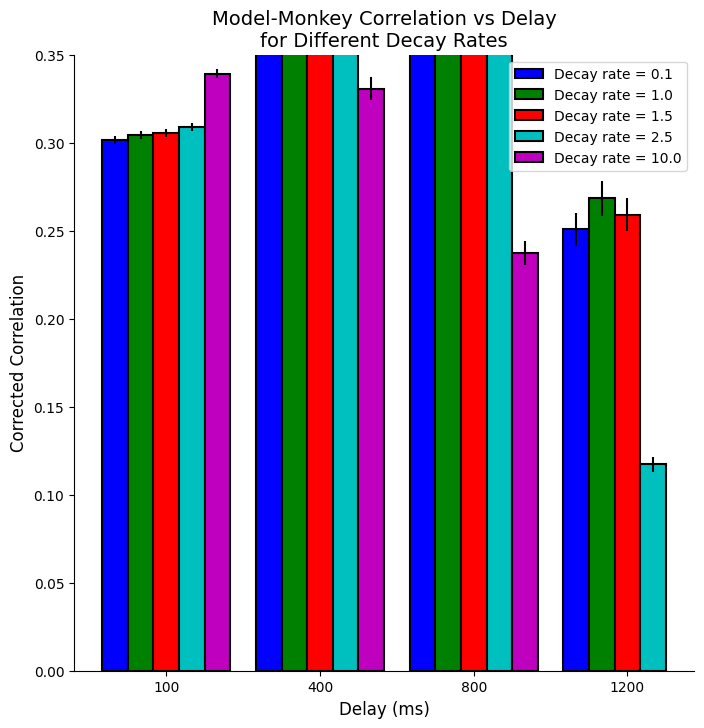

In [13]:
# Example usage
delays = [100, 400, 800, 1200]

decay_rates = [0.1, 1, 1.5, 2.5, 10]
monkey_path = "../hypothesis_wm_experiments/data/monkey_behavioral_data/"
reliability_base_dir = "../hypothesis_wm_experiments/behavioral_metrics_results/"
all_results = process_all_decays_and_delays(
    decay_rates=decay_rates,
    delays=delays,
    monkey_path=monkey_path,
    reliability_base_dir=reliability_base_dir
)

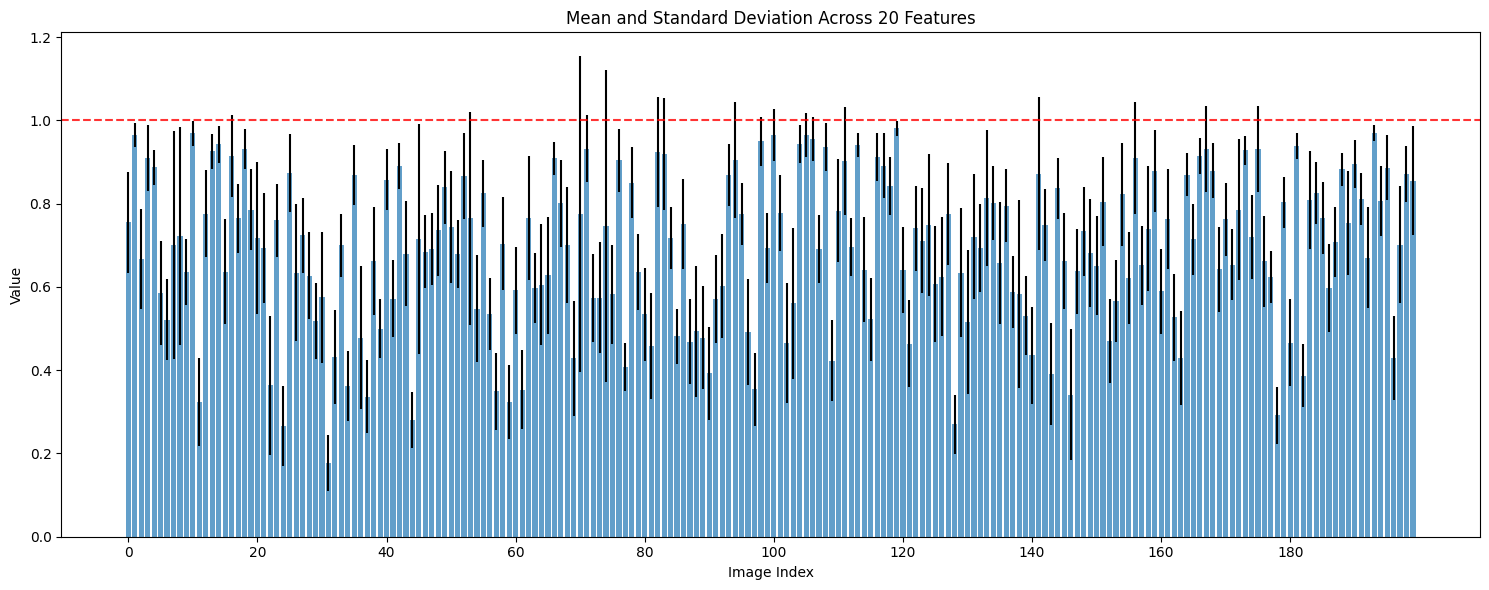

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stats(data, figsize=(15, 6)):
    # Calculate mean and std across features (axis 1)
    means = np.mean(data, axis=1)  # shape: (200,)
    stds = np.std(data, axis=1)    # shape: (200,)
    
    # Create x-axis positions for bars
    x = np.arange(len(means))
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot bars with error bars (no caps)
    plt.bar(x, means, yerr=stds, capsize=0, alpha=0.7)
    
    # Add horizontal line at y=1.0
    plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.8)
    
    # Customize the plot
    plt.xlabel('Image Index')
    plt.ylabel('Value')
    plt.title('Mean and Standard Deviation Across 20 Features')
    
    # Set x-ticks at reasonable intervals to avoid overcrowding
    plt.xticks(np.arange(0, 200, 20))
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt

# Assuming your data is stored in a variable called 'results'
# Example usage:
plot = plot_stats(results[100])
plt.show()

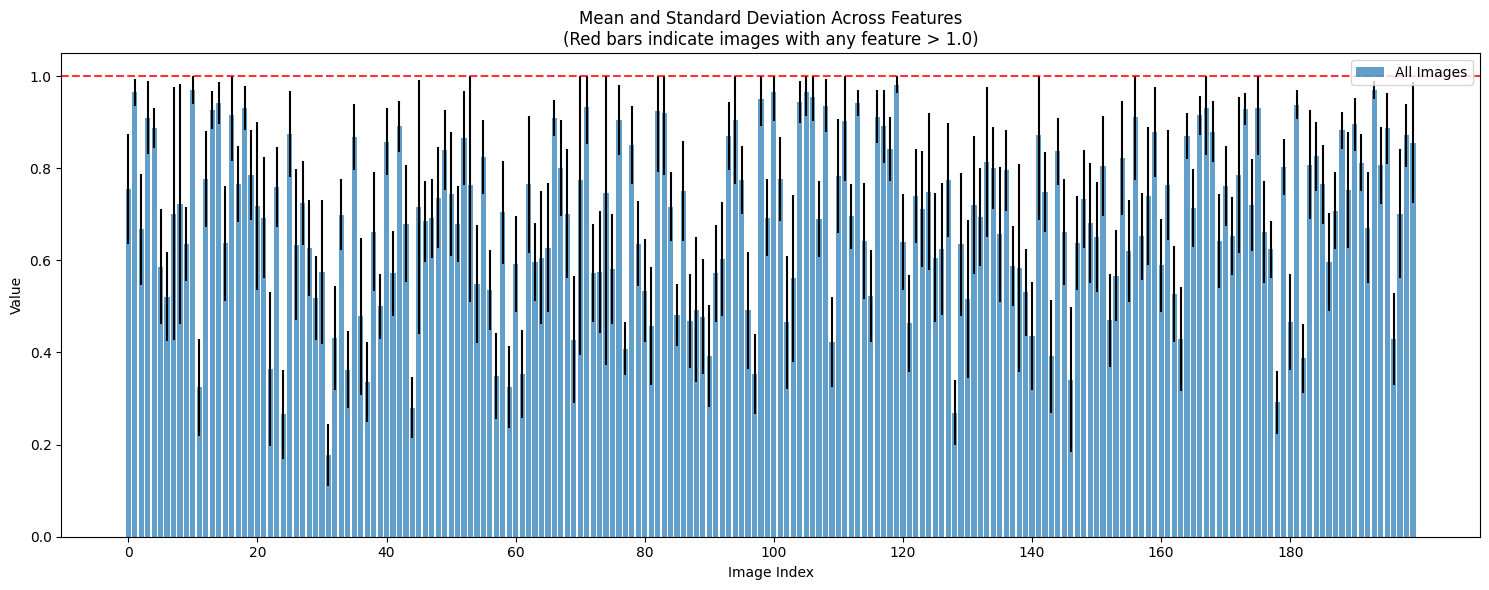

In [20]:
def find_high_predictions(data, threshold=1.0):
    # Find images where any feature exceeds threshold
    high_indices = np.where(np.any(data > threshold, axis=1))[0]
    
    # Calculate mean across features for these images
    means = np.mean(data, axis=1)
    high_means = means[high_indices]
    
    # Get maximum value for each high index
    max_values = np.max(data[high_indices], axis=1)
    
    # Print results
    print(f"Found {len(high_indices)} images with at least one feature above {threshold}:")
    print("\nIndex  |  Max Value  |  Mean Value")
    print("-" * 40)
    for idx, max_val, mean_val in zip(high_indices, max_values, high_means):
        print(f"{idx:5d}  |  {max_val:9.4f}  |  {mean_val:.4f}")
        
    return high_indices, max_values

def plot_stats_with_highlights(data, threshold=1.0, figsize=(15, 6)):
    # Calculate mean and std across features
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    
    # Create plot
    plt.figure(figsize=figsize)
    
    # Calculate yerr with clipping
    yerr_low = means
    yerr_high = np.minimum(means + stds, np.ones_like(means)) - means
    yerr = np.vstack((yerr_low - (means - stds), yerr_high))
    
    # Plot all bars
    x = np.arange(len(means))
    plt.bar(x, means, yerr=yerr, capsize=0, alpha=0.7, label='All Images')
    
    # Find images where any feature exceeds threshold
    high_indices = np.where(np.any(data > threshold, axis=1))[0]
    
    # Highlight bars where any feature exceeds threshold
    if len(high_indices) > 0:
        yerr_high_subset = np.minimum(means[high_indices] + stds[high_indices], 
                                    np.ones_like(means[high_indices])) - means[high_indices]
        yerr_subset = np.vstack((yerr_low[high_indices] - (means[high_indices] - stds[high_indices]), 
                               yerr_high_subset))
        
        plt.bar(high_indices, means[high_indices], yerr=yerr_subset,
                capsize=0, alpha=0.7, color='r', 
                label=f'Has feature(s) above {threshold}')
    
    # Add horizontal line
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.8)
    
    # Set y-axis limits explicitly
    plt.ylim(0, 1.05)  # Giving a tiny bit of padding above 1.0 for the line visibility
    
    # Customize plot
    plt.xlabel('Image Index')
    plt.ylabel('Value')
    plt.title('Mean and Standard Deviation Across Features\n(Red bars indicate images with any feature > 1.0)')
    plt.xticks(np.arange(0, 200, 20))
    plt.legend()
    
    plt.tight_layout()
    return plt

# Example usage:
# high_indices, max_values = find_high_predictions(results[100])


plot = plot_stats_with_highlights(results[100])
plt.show()

In [53]:
def load_reliability_data(delay: int, base_dir: str = "behavioral_metrics_results") -> np.ndarray:
    """Load reliability data for a specific delay"""
    reliability_path = os.path.join(base_dir, f'delay_{delay}ms/bi1/reliabilities.npy')
    return np.load(reliability_path)

def load_model_data(delay: int, decay:float):
    analyzer = DecayAnalyzer(decay=decay)
    results, accuracies = analyzer.analyze_all_delays([delay])
    return np.nanmean(results[delay], axis=1)

def load_monkey_data(delay: int, base_dir: str):
    monkey_template = "b_i1_delay_{}.npy"
    monkey_template = monkey_template.format(delay)
    monkey_file = os.path.join(base_dir, monkey_template)
    monkey_data = np.load(monkey_file)
    return monkey_data.ravel()

def calculate_corrected_correlation(
    model_data: np.ndarray,
    monkey_data: np.ndarray,
    monkey_reliability: np.ndarray
):
    """
    Calculate noise-ceiling corrected correlation and its standard deviation
    """
    # Calculate raw correlation
    raw_corr, p_val = stats.pearsonr(model_data, monkey_data)
    
    # Calculate corrected correlations for each reliability value
    corrected_corrs = []
    for rel in monkey_reliability:
        # Correct correlation by dividing by sqrt(reliability)
        corrected_corr = raw_corr / np.sqrt(rel)
        # Ensure correlation doesn't exceed 1
        corrected_corr = min(corrected_corr, 1.0)
        corrected_corrs.append(corrected_corr)
    
    # Calculate mean and std of corrected correlations
    mean_corrected = np.mean(corrected_corrs)
    std_corrected = np.std(corrected_corrs)
    
    return raw_corr, mean_corrected, std_corrected, p_val

def create_results_directory(decay: float):
    """
    Create a directory for storing correlation results.
    Returns the path to the created directory.
    """
    base_dir = "correlation_monkey_and_model_noise_ceiling"
    # Add timestamp to avoid overwriting
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # results_dir = f"{base_dir}_{timestamp}"
    results_dir = f"{base_dir}_{decay}"
    
    
    # Create directory if it doesn't exist
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
        print(f"Created results directory: {results_dir}")
    
    return results_dir

def plot_correlation_summary_with_error(
    results,
    results_dir: str,
    filename: str = 'correlation_summary_simple.png'
):
    """
    Create a simple bar plot with error bars from correlation results
    """
    plt.figure(figsize=(10, 6))
    
    # Extract data
    delays = [int(delay) for delay in results.keys()]
    correlations = [result['corrected_correlation'] for result in results.values()]
    errors = [result['correlation_std'] for result in results.values()]
    
    # Create bar plot with error bars
    plt.bar(delays, correlations,
            width=200,
            edgecolor='black',
            linewidth=1.5,
            yerr=errors,
            capsize=0,
            error_kw={'linewidth': 1.5})
    
    # Save plot
    save_path = os.path.join(results_dir, filename)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"Saved simple correlation plot: {save_path}")


def plot_correlation(model_data, monkey_data, delay, r, p):
    """
    Create a scatter plot of model vs monkey behavioral data.
    
    Parameters:
    -----------
    model_data : array-like
        Model behavioral data
    monkey_data : array-like
        Monkey behavioral data
    delay : int
        Delay time in milliseconds
    r : float
        Correlation coefficient
    p : float
        P-value of correlation
    """
    plt.figure(figsize=(8, 8))
    
    # Create scatter plot
    sns.scatterplot(x=monkey_data, y=model_data, alpha=0.5)
    
    # Add correlation line
    z = np.polyfit(monkey_data, model_data, 1)
    p_fit = np.poly1d(z)
    plt.plot(monkey_data, p_fit(monkey_data), "r--", alpha=0.8, label='Correlation Line')
    
    # Add labels and title
    plt.xlabel('Monkey Behavior')
    plt.ylabel('Model Behavior')
    plt.title(f'Model vs Monkey Behavior Correlation\nDelay: {delay}ms, r={r:.3f}, p={p:.3e}')
    
    # Add unity line
    min_val = min(plt.xlim()[0], plt.ylim()[0])
    max_val = max(plt.xlim()[1], plt.ylim()[1])
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, label='Unity Line')
    
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    
    return plt.gcf()

def process_all_delays_with_reliability(
    delays,
    monkey_path: str,
    decay: float = 1.5,
    reliability_base_dir: str = "behavioral_metrics_results"
):
    """
    Process and save results for all delays with reliability correction
    """
    # Create results directory
    results_dir = create_results_directory(decay=decay)
    
    # Dictionary to store all results
    all_results = {}
    
    # Process each delay
    for delay in delays:
        print(f"\nProcessing delay: {delay}ms")
        
        # Load behavior data
        monkey_data = load_monkey_data(delay=delay, base_dir=monkey_path)
        model_data = load_model_data(delay=delay, decay=decay)
        
        # Load reliability data
        reliability_data = load_reliability_data(delay=delay, base_dir=reliability_base_dir)

        
        # Calculate corrected correlation
        raw_r, corrected_r, r_std, p_value = calculate_corrected_correlation(
            model_data, monkey_data, reliability_data
        )
        
        # Store results
        all_results[str(delay)] = {
            'raw_correlation': float(raw_r),
            'corrected_correlation': float(corrected_r),
            'correlation_std': float(r_std),
            'p_value': float(p_value)
        }
        
        # Create and save individual correlation plots
        fig = plot_correlation(model_data, monkey_data, delay, corrected_r, p_value)
        plot_filename = os.path.join(results_dir, f'correlation_plot_{delay}ms.png')
        fig.savefig(plot_filename)
        plt.close(fig)
        
        # Save raw data
        data_filename = os.path.join(results_dir, f'correlation_data_{delay}ms.npz')
        np.savez(data_filename,
                 model_data=model_data,
                 monkey_data=monkey_data,
                 reliability_data=reliability_data)
    
    # Create and save summary plot with error bars
    plot_correlation_summary_with_error(all_results, results_dir)
    
    # Save summary results
    results_filename = os.path.join(results_dir, 'correlation_results.json')
    with open(results_filename, 'w') as f:
        json.dump(all_results, f, indent=4)
    
    return results_dir, all_results

# delay = 100

# base_dir = "../hypothesis_wm_experiments/data/monkey_behavioral_data/"
# monkey_data = load_monkey_data(delay=delay, base_dir=base_dir)
# print(f"{monkey_data.shape = }")

# base_dir = "../hypothesis_wm_experiments/behavioral_metrics_results/"
# monkey_reliability = load_reliability_data(delay=delay, base_dir=base_dir)
# print(f"{monkey_reliability.shape = }")

# model_data = load_model_data(delay=delay, decay=1.5)
# print(f"{model_data.shape = }")

delays = [100, 400, 800, 1200]
monkey_path = "../hypothesis_wm_experiments/data/monkey_behavioral_data/"
decay = 0.1
reliability_base_dir = "../hypothesis_wm_experiments/behavioral_metrics_results/"
process_all_delays_with_reliability(delays=delays, monkey_path=monkey_path, decay=decay, reliability_base_dir=reliability_base_dir)

Created results directory: correlation_monkey_and_model_noise_ceiling_0.1

Processing delay: 100ms

Analyzing delay 100ms...


delay_ms = 100: 100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Accuracy: 0.692

Overall Behavioral Accuracies:
Delay 100ms: 0.692

Processing delay: 400ms

Analyzing delay 400ms...


delay_ms = 400: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Accuracy: 0.691

Overall Behavioral Accuracies:
Delay 400ms: 0.691

Processing delay: 800ms

Analyzing delay 800ms...


delay_ms = 800: 100%|██████████| 20/20 [00:31<00:00,  1.60s/it]


Accuracy: 0.690

Overall Behavioral Accuracies:
Delay 800ms: 0.690

Processing delay: 1200ms

Analyzing delay 1200ms...


delay_ms = 1200: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


Accuracy: 0.689

Overall Behavioral Accuracies:
Delay 1200ms: 0.689
Saved corrected correlation summary plot: correlation_monkey_and_model_noise_ceiling_0.1/correlation_summary_corrected.png


('correlation_monkey_and_model_noise_ceiling_0.1',
 {'100': {'raw_correlation': 0.2594286518978503,
   'corrected_correlation': 0.27508342830513277,
   'correlation_std': 0.002035711732759544,
   'p_value': 0.000207592186765744},
  '400': {'raw_correlation': 0.25681539749927035,
   'corrected_correlation': 0.29863579796520034,
   'correlation_std': 0.006062768643861689,
   'p_value': 0.00024168424077008175},
  '800': {'raw_correlation': 0.1670664346897176,
   'corrected_correlation': 0.20704235679646263,
   'correlation_std': 0.006128318633590973,
   'p_value': 0.018053978108560208},
  '1200': {'raw_correlation': 0.16729482752953734,
   'corrected_correlation': 0.21749544427985382,
   'correlation_std': 0.007969508915898121,
   'p_value': 0.01789478700743263}})

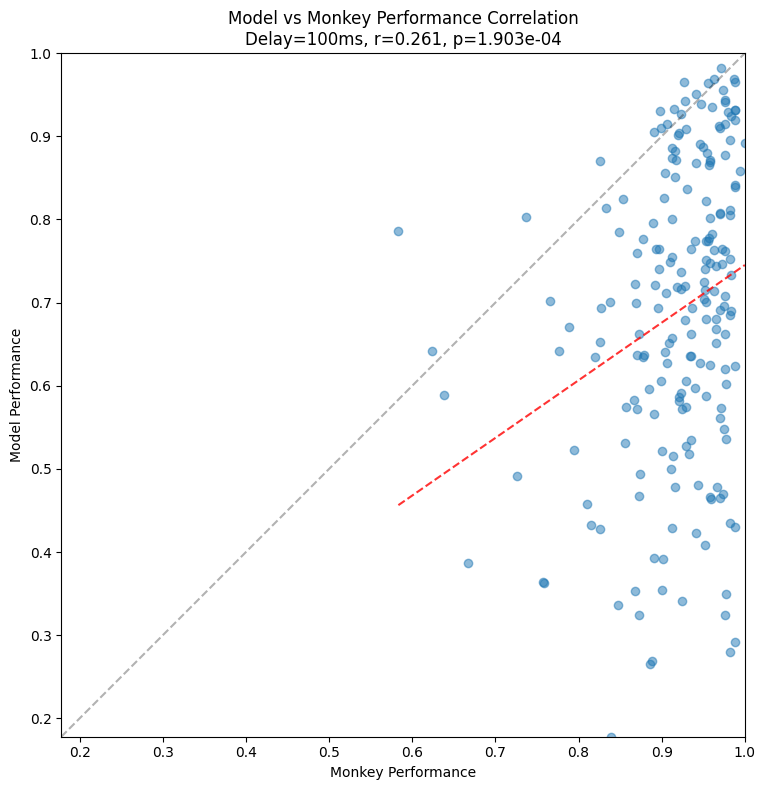

In [33]:
def plot_correlation(monkey_data, model_data, delay, decay=1.5, figsize=(10, 8)):
    # Calculate correlation for the title
    corr, p_val = stats.pearsonr(monkey_data.ravel(), model_data)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Create scatter plot
    plt.scatter(monkey_data.ravel(), model_data, alpha=0.5)
    
    # Add line of best fit
    z = np.polyfit(monkey_data.ravel(), model_data, 1)
    p = np.poly1d(z)
    x_range = np.linspace(monkey_data.min(), monkey_data.max(), 100)
    plt.plot(x_range, p(x_range), 'r--', alpha=0.8)
    
    # Add labels and title
    plt.xlabel('Monkey Performance')
    plt.ylabel('Model Performance')
    plt.title(f'Model vs Monkey Performance Correlation\nDelay={delay}ms, r={corr:.3f}, p={p_val:.3e}')
    
    # Add grid
    plt.grid(False)
    
    # Make plot square
    plt.axis('square')
    
    # Add identity line (y=x)
    min_val = min(monkey_data.min(), model_data.min())
    max_val = max(monkey_data.max(), model_data.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
    
    # Set axes limits
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)
    
    plt.tight_layout()
    return plt

# Example usage
plot = plot_correlation(monkey_data, model_data, delay=delay)
plt.show()